In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import IPython.display
import librosa
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [22]:
file_path = '/Users/atrix/Documents/desktop_folders/Programming/tensorflow/archive'
file_viz = glob.glob('/Users/atrix/Documents/desktop_folders/Programming/tensorflow/archive/fold1/*')
urbansound8k = pd.read_csv("/Users/atrix/Documents/desktop_folders/Programming/tensorflow/archive/UrbanSound8K.csv")

In [23]:
urbansound8k.head()

slice_file_name    fsID  start        end  salience  fold  classID   
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3  \
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [24]:
class_map = {'0' : 'air_conditioner',
             '1' : 'car_horn',
             '2' : 'children_playing', 
             '3' : 'dog_bark', 
             '4' : 'drilling', 
             '5' : 'engine_idling', 
             '6' : 'gun_shot',
             '7' : 'jackhammer',
             '8' : 'siren',
             '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

0                 1
0  0   air_conditioner
1  1          car_horn
2  2  children_playing
3  3          dog_bark
4  4          drilling
5  5     engine_idling
6  6          gun_shot
7  7        jackhammer
8  8             siren
9  9      street_music

In [25]:
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [26]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, orig_sr=fsr, target_sr=sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (88200,)),
 ('car_horn', (10264,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (25104,)),
 ('jackhammer', (63284,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

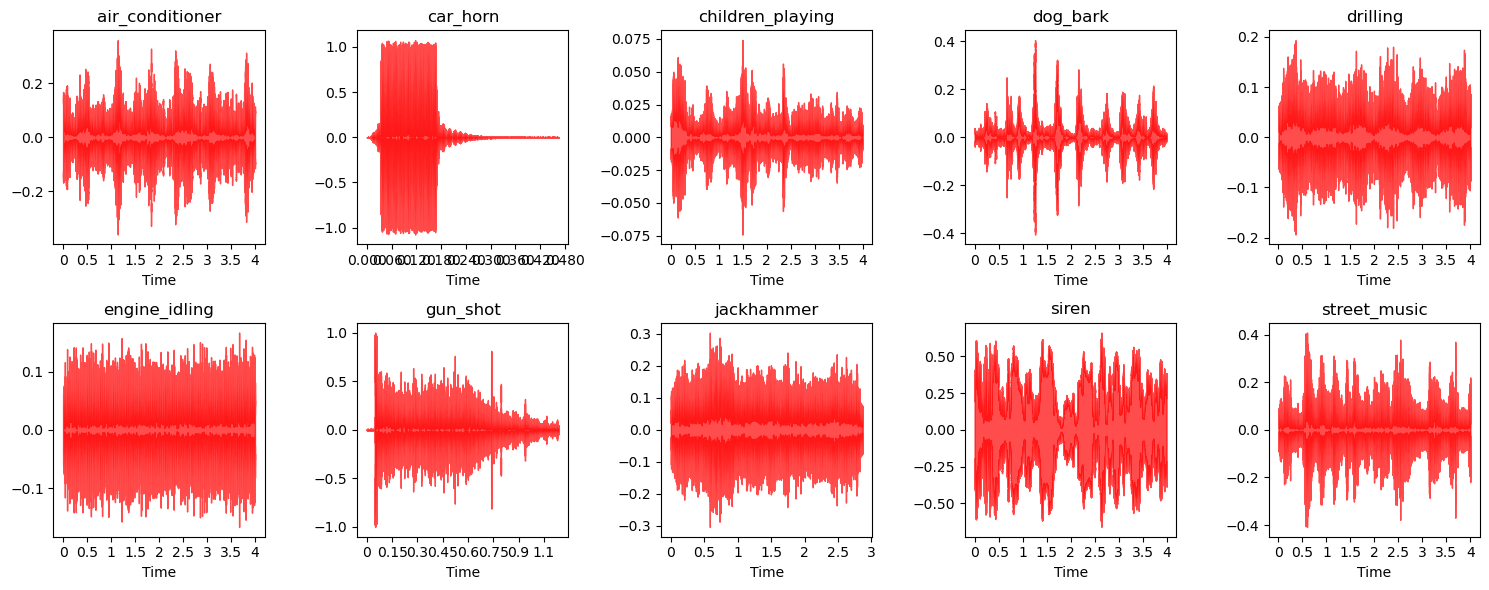

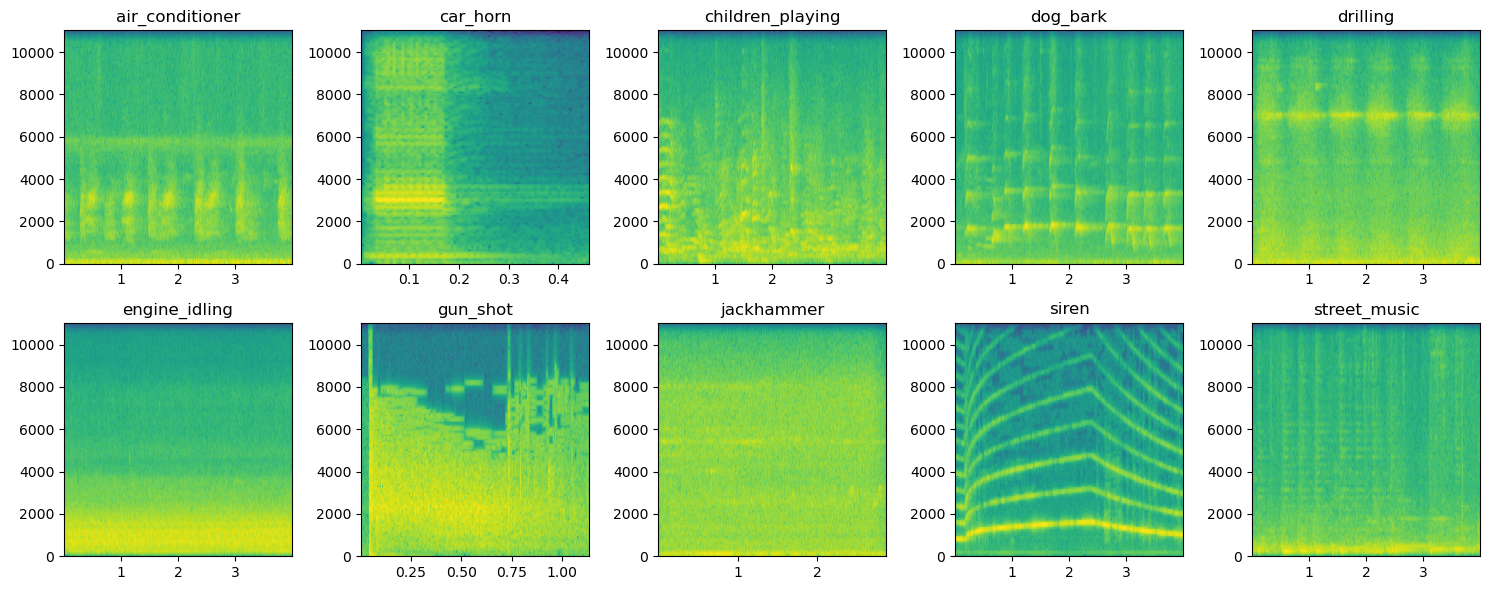

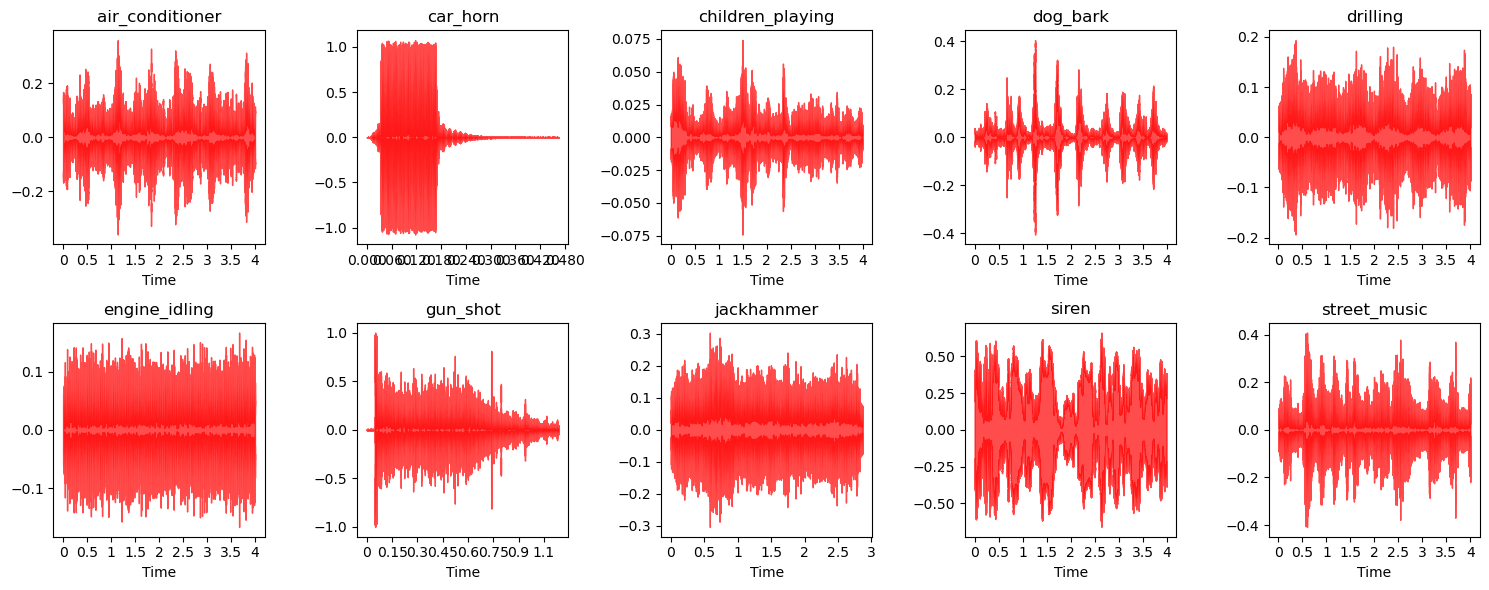

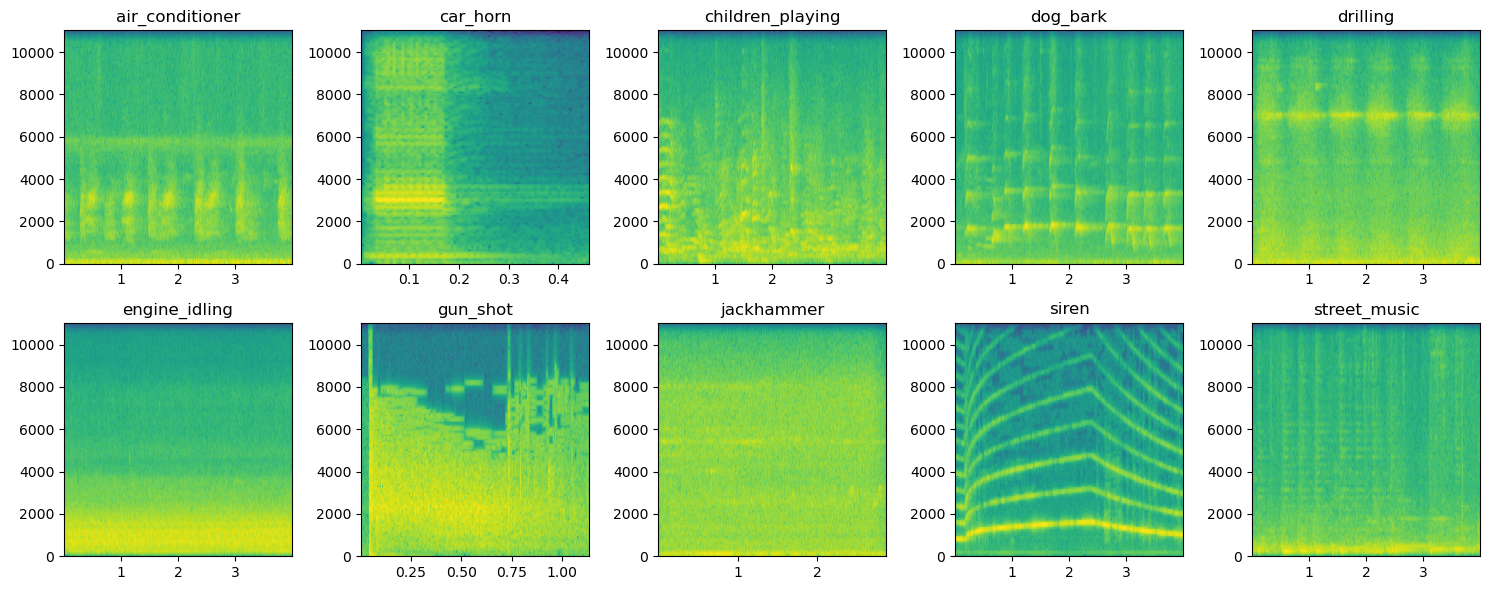

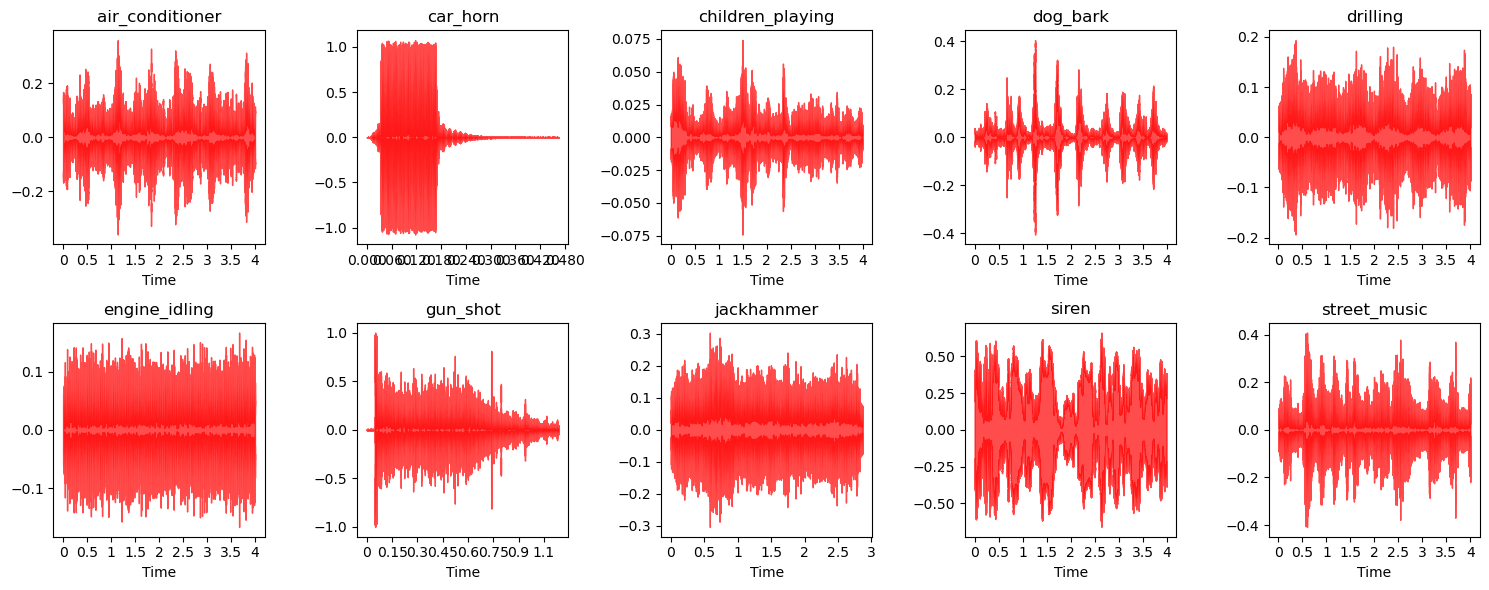

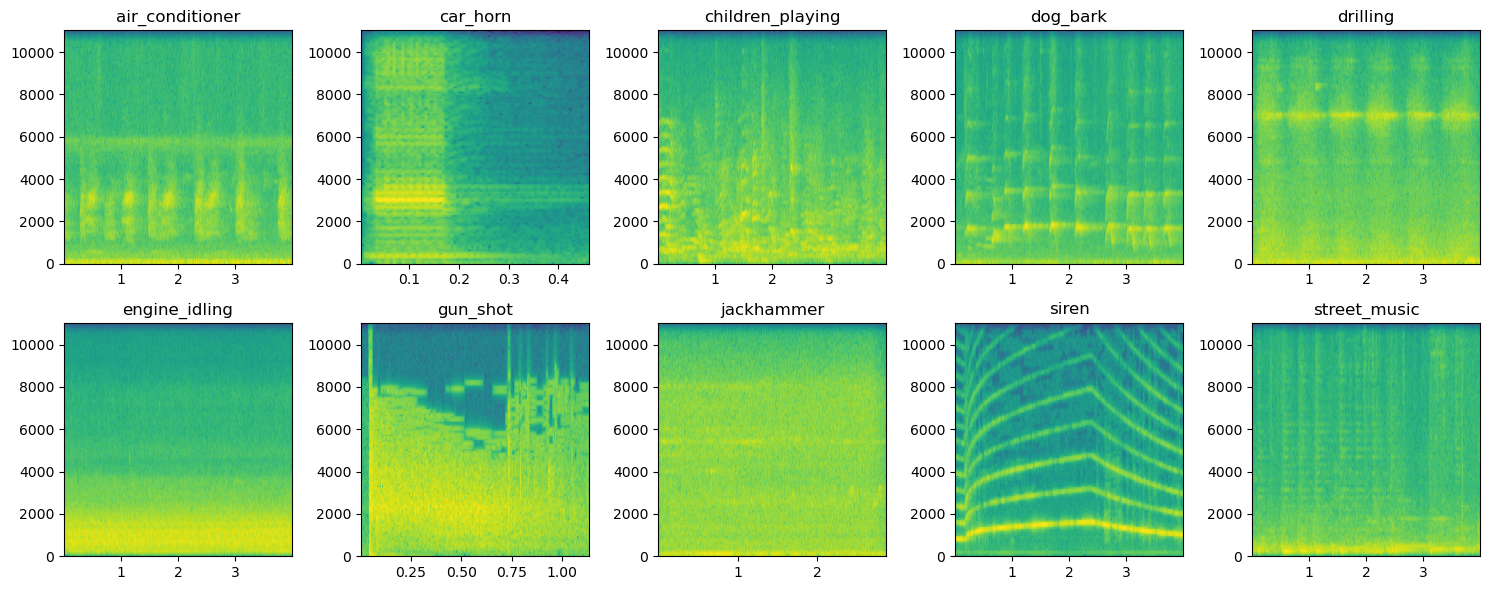

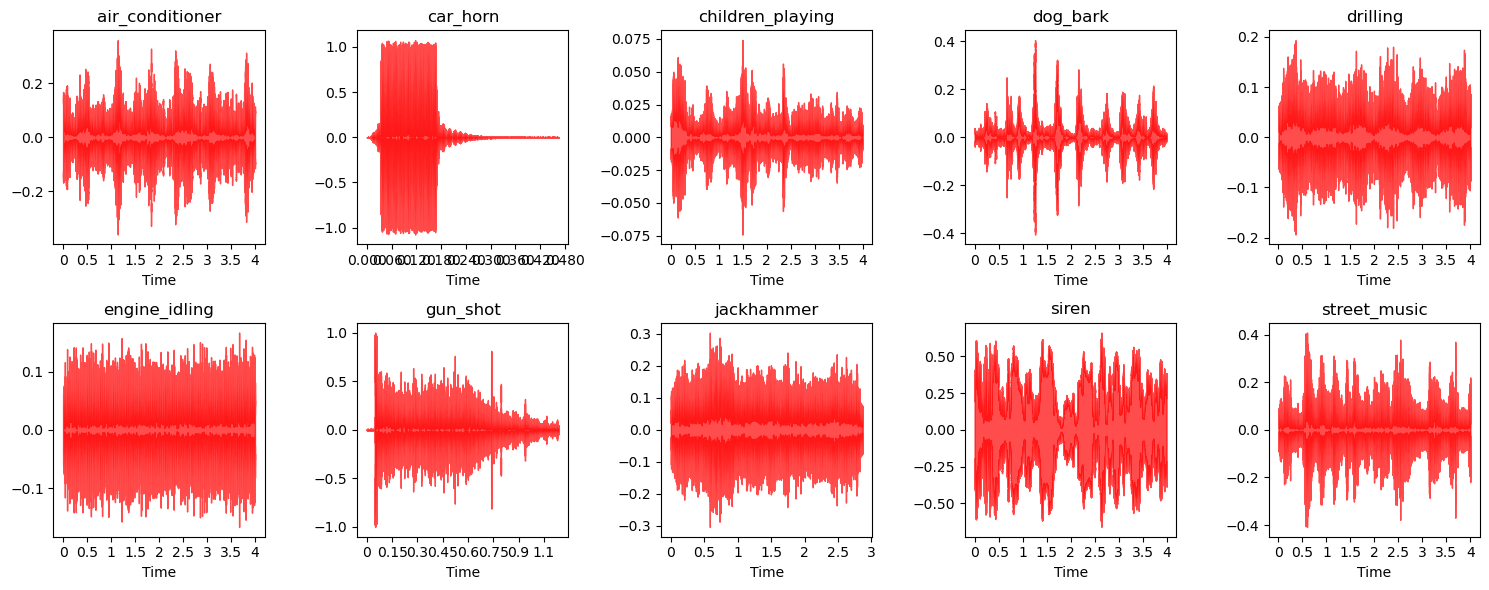

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [27]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

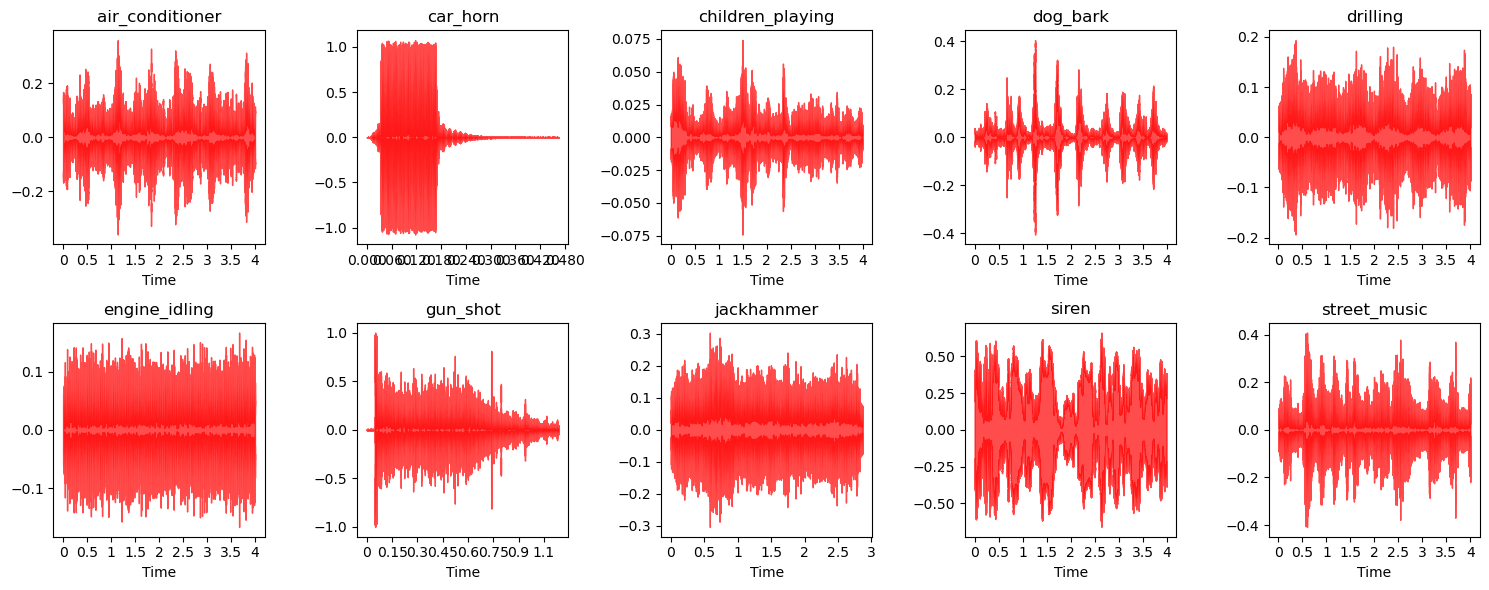

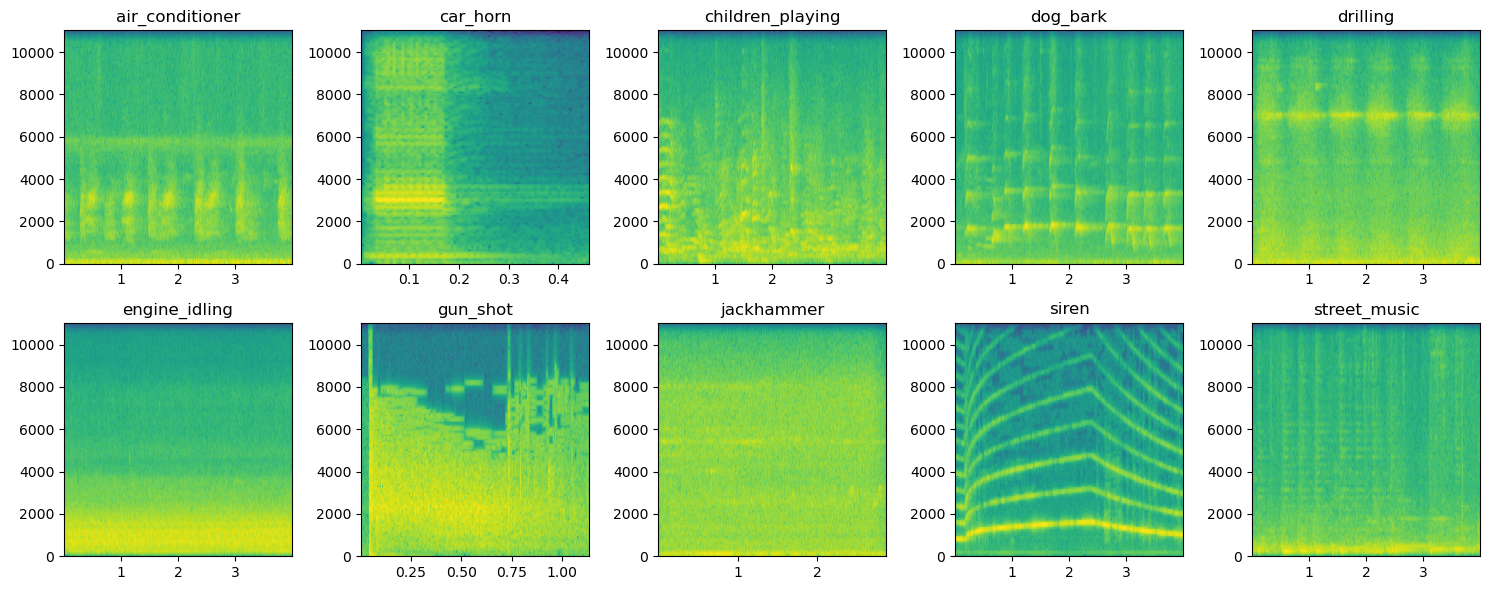

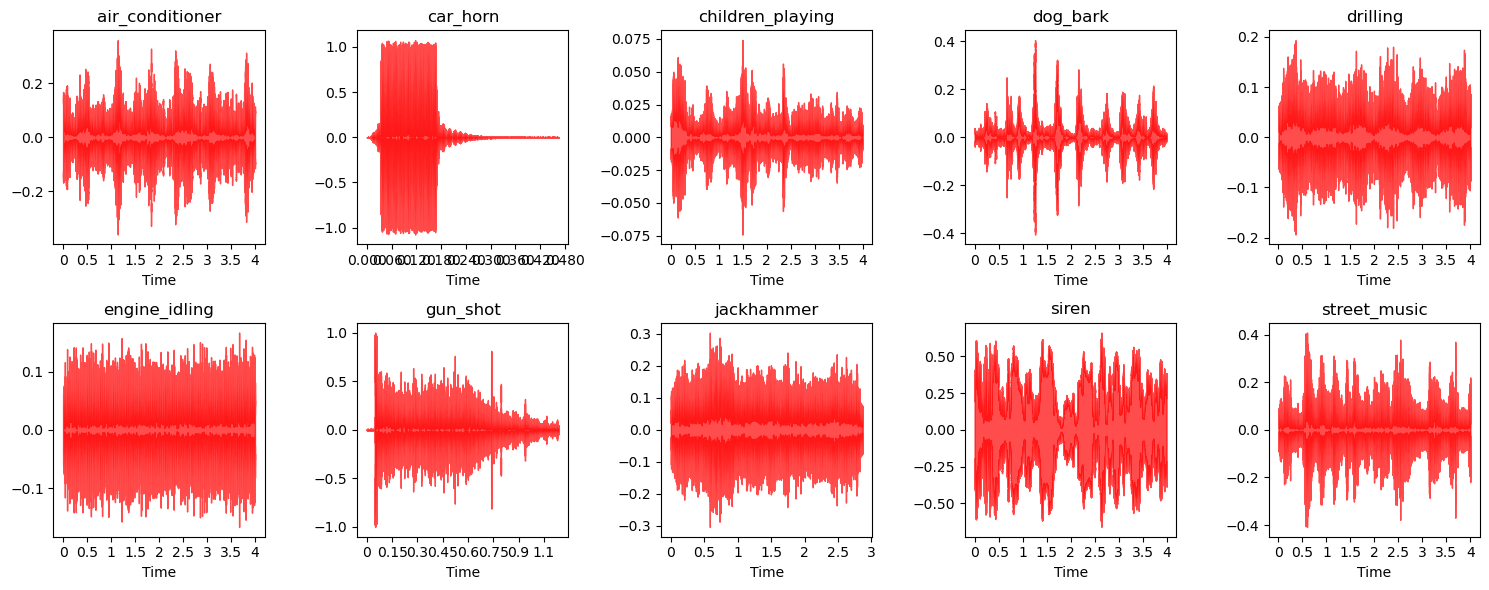

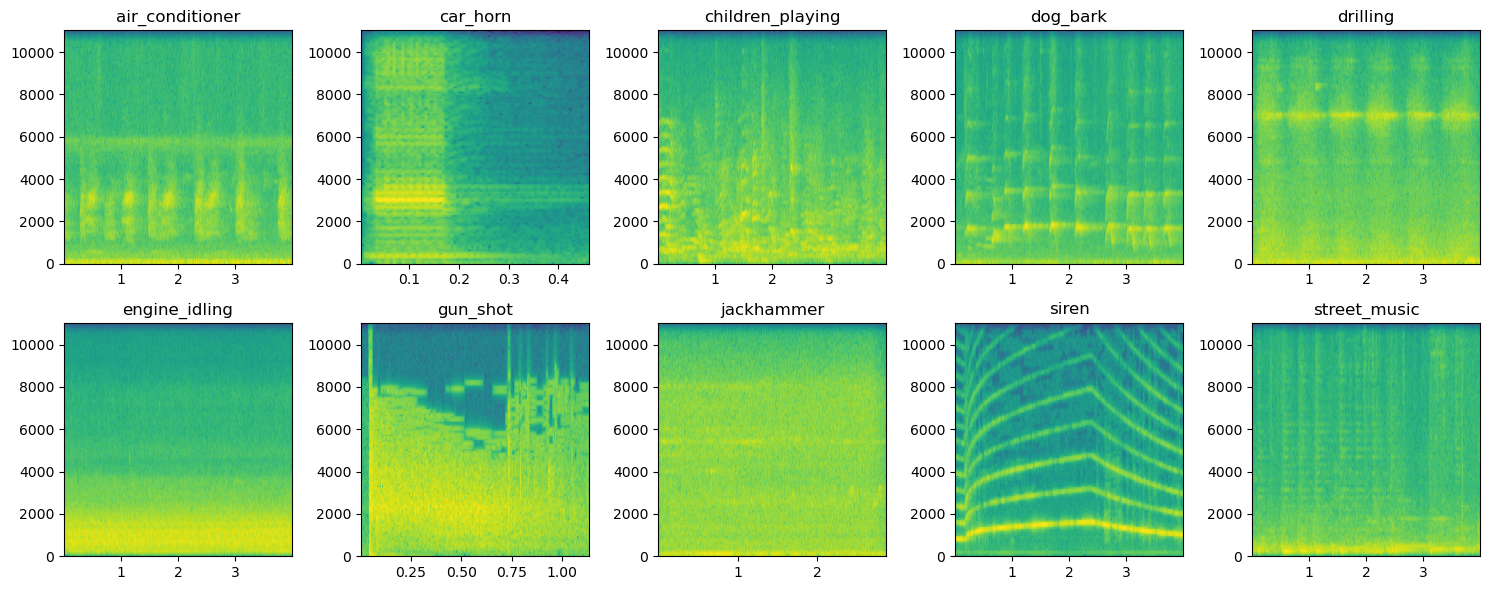

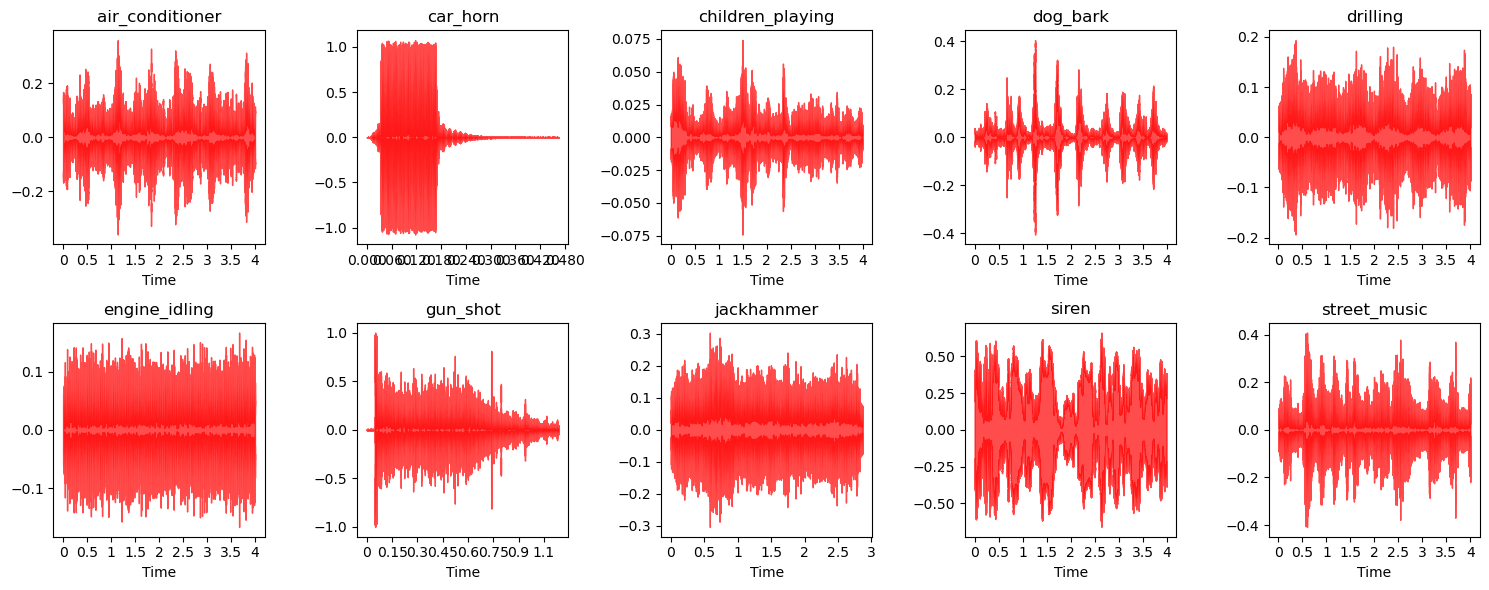

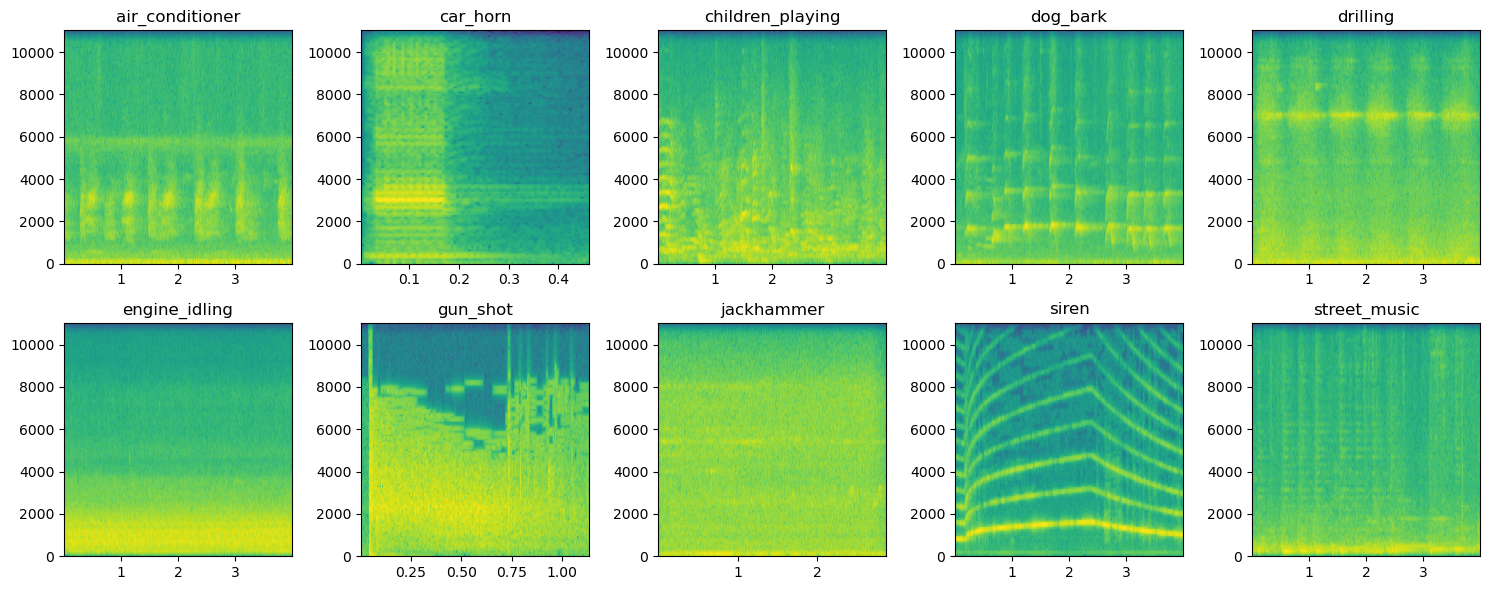

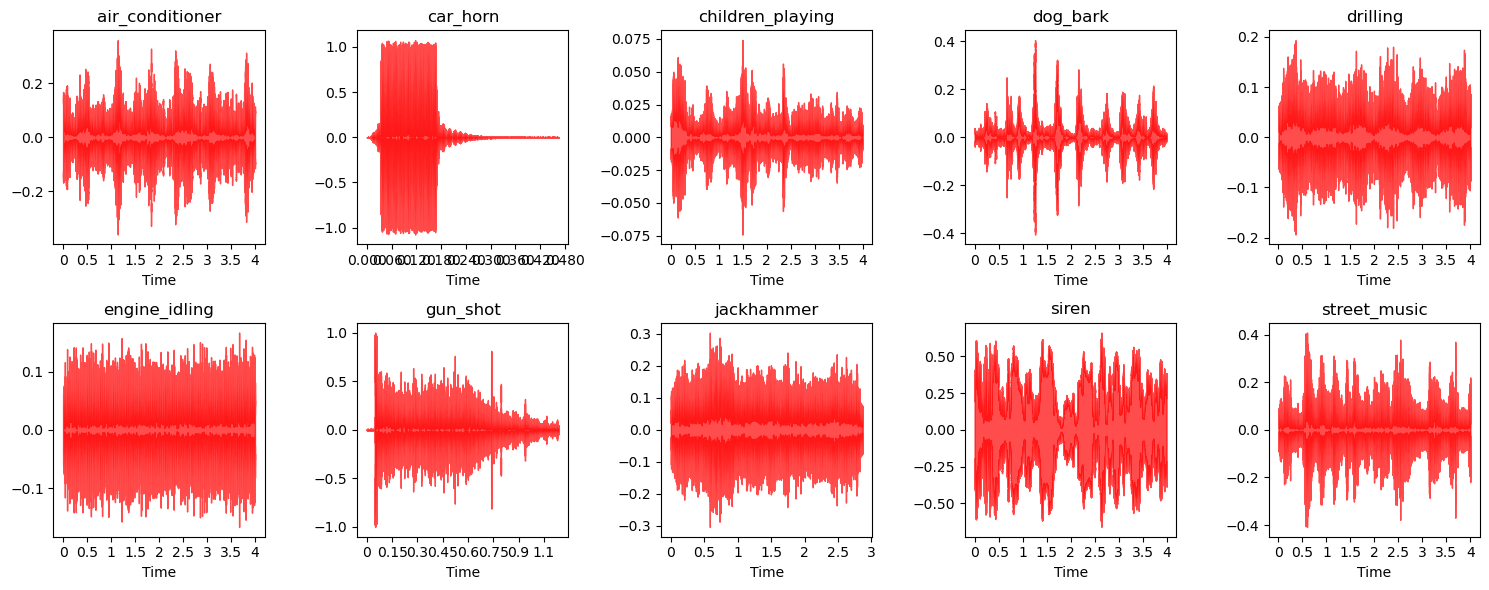

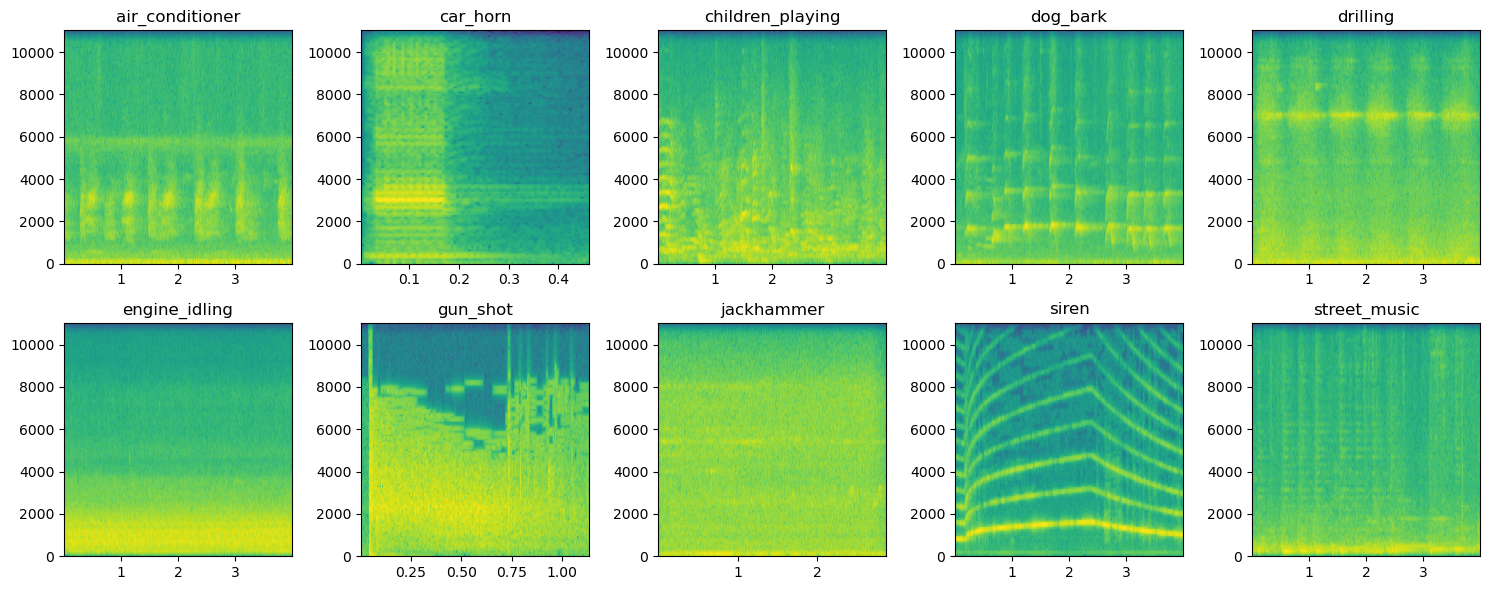

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [28]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

In [29]:
class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [31]:
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in urbansound8k.iterrows():
    
    file_name = "/Users/atrix/Documents/desktop_folders/Programming/tensorflow/archive/fold"+str(row["fold"])+'/'+str(row["slice_file_name"])
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [35]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [37]:
features = []

# Iterate through each sound file and extract the features 
for index, row in urbansound8k.iterrows():
    
    file_name = "/Users/atrix/Documents/desktop_folders/Programming/tensorflow/archive/fold"+str(row["fold"])+'/'+str(row["slice_file_name"])
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/Users/atrix/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/atrix/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/atrix/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [38]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

In [39]:
x_train1 = x_train 
x_test1 = x_test
y_train1 = y_train
y_test1 = y_test
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

6985
1747
6985
1747


In [40]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(6985, 40, 174, 1)


In [41]:
model_relu = Sequential()
model_relu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))
model_relu.add(GlobalAveragePooling2D())
model_relu.add(Flatten())
model_relu.add(Dense(num_labels, activation='softmax'))

Metal device set to: Apple M1 Pro


In [42]:
model_relu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [43]:
model_relu.summary()

# Calculate pre-training accuracy 
score = model_relu.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

2023-04-24 11:01:05.722259: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


55/55 [==============================] - 3s 10ms/step - loss: 8.0885 - accuracy: 0.0355
Pre-training accuracy: 3.5489%


In [44]:
num_epochs = 300
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_relu = model_relu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
28/28 [==============================] - ETA: 0s - loss: 4.3127 - accuracy: 0.1482
Epoch 1: val_loss improved from inf to 2.17631, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 6s 71ms/step - loss: 4.3127 - accuracy: 0.1482 - val_loss: 2.1763 - val_accuracy: 0.1952
Epoch 2/300
27/28 [===========================>..] - ETA: 0s - loss: 2.0417 - accuracy: 0.2661
Epoch 2: val_loss improved from 2.17631 to 1.98041, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 45ms/step - loss: 2.0403 - accuracy: 0.2670 - val_loss: 1.9804 - val_accuracy: 0.3349
Epoch 3/300
27/28 [===========================>..] - ETA: 0s - loss: 1.7834 - accuracy: 0.3659
Epoch 3: val_loss improved from 1.98041 to 1.82794, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 45ms/step - loss: 1.7852 - accuracy: 0.3658 - val_loss: 1.8279 - val_accuracy: 0.4219
Ep

27/28 [===========================>..] - ETA: 0s - loss: 0.6161 - accuracy: 0.7930
Epoch 26: val_loss improved from 0.75915 to 0.70924, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 45ms/step - loss: 0.6178 - accuracy: 0.7920 - val_loss: 0.7092 - val_accuracy: 0.7750
Epoch 27/300
27/28 [===========================>..] - ETA: 0s - loss: 0.6109 - accuracy: 0.7946
Epoch 27: val_loss did not improve from 0.70924
28/28 [==============================] - 1s 43ms/step - loss: 0.6096 - accuracy: 0.7946 - val_loss: 0.7266 - val_accuracy: 0.7653
Epoch 28/300
27/28 [===========================>..] - ETA: 0s - loss: 0.6164 - accuracy: 0.7969
Epoch 28: val_loss did not improve from 0.70924
28/28 [==============================] - 1s 43ms/step - loss: 0.6164 - accuracy: 0.7967 - val_loss: 0.7272 - val_accuracy: 0.7705
Epoch 29/300
28/28 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.8019
Epoch 29: val_loss improved from 

27/28 [===========================>..] - ETA: 0s - loss: 0.3609 - accuracy: 0.8776
Epoch 53: val_loss did not improve from 0.45935
28/28 [==============================] - 1s 43ms/step - loss: 0.3598 - accuracy: 0.8777 - val_loss: 0.5961 - val_accuracy: 0.8014
Epoch 54/300
27/28 [===========================>..] - ETA: 0s - loss: 0.3410 - accuracy: 0.8854
Epoch 54: val_loss did not improve from 0.45935
28/28 [==============================] - 1s 43ms/step - loss: 0.3421 - accuracy: 0.8852 - val_loss: 0.5050 - val_accuracy: 0.8340
Epoch 55/300
27/28 [===========================>..] - ETA: 0s - loss: 0.3618 - accuracy: 0.8717
Epoch 55: val_loss did not improve from 0.45935
28/28 [==============================] - 1s 43ms/step - loss: 0.3603 - accuracy: 0.8722 - val_loss: 0.5243 - val_accuracy: 0.8277
Epoch 56/300
27/28 [===========================>..] - ETA: 0s - loss: 0.3339 - accuracy: 0.8893
Epoch 56: val_loss did not improve from 0.45935
28/28 [==============================] - 1s 43m

28/28 [==============================] - 1s 44ms/step - loss: 0.2424 - accuracy: 0.9161 - val_loss: 0.3630 - val_accuracy: 0.8815
Epoch 82/300
27/28 [===========================>..] - ETA: 0s - loss: 0.2435 - accuracy: 0.9151
Epoch 82: val_loss did not improve from 0.36298
28/28 [==============================] - 1s 42ms/step - loss: 0.2429 - accuracy: 0.9152 - val_loss: 0.3885 - val_accuracy: 0.8809
Epoch 83/300
27/28 [===========================>..] - ETA: 0s - loss: 0.2446 - accuracy: 0.9165
Epoch 83: val_loss did not improve from 0.36298
28/28 [==============================] - 1s 42ms/step - loss: 0.2445 - accuracy: 0.9165 - val_loss: 0.4018 - val_accuracy: 0.8821
Epoch 84/300
27/28 [===========================>..] - ETA: 0s - loss: 0.2330 - accuracy: 0.9217
Epoch 84: val_loss did not improve from 0.36298
28/28 [==============================] - 1s 43ms/step - loss: 0.2329 - accuracy: 0.9215 - val_loss: 0.4196 - val_accuracy: 0.8695
Epoch 85/300
27/28 [===========================>

Epoch 111/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1632 - accuracy: 0.9433
Epoch 111: val_loss did not improve from 0.32767
28/28 [==============================] - 1s 43ms/step - loss: 0.1620 - accuracy: 0.9437 - val_loss: 0.3362 - val_accuracy: 0.9078
Epoch 112/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1695 - accuracy: 0.9392
Epoch 112: val_loss did not improve from 0.32767
28/28 [==============================] - 1s 43ms/step - loss: 0.1705 - accuracy: 0.9389 - val_loss: 0.3793 - val_accuracy: 0.8878
Epoch 113/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1650 - accuracy: 0.9424
Epoch 113: val_loss improved from 0.32767 to 0.32341, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 45ms/step - loss: 0.1650 - accuracy: 0.9424 - val_loss: 0.3234 - val_accuracy: 0.9056
Epoch 114/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1606 - accuracy: 0.9437
Epoch 114: va

28/28 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9490
Epoch 140: val_loss did not improve from 0.28819
28/28 [==============================] - 1s 44ms/step - loss: 0.1288 - accuracy: 0.9490 - val_loss: 0.3233 - val_accuracy: 0.9147
Epoch 141/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1211 - accuracy: 0.9589
Epoch 141: val_loss did not improve from 0.28819
28/28 [==============================] - 1s 42ms/step - loss: 0.1209 - accuracy: 0.9591 - val_loss: 0.3178 - val_accuracy: 0.9176
Epoch 142/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1224 - accuracy: 0.9562
Epoch 142: val_loss did not improve from 0.28819
28/28 [==============================] - 1s 43ms/step - loss: 0.1220 - accuracy: 0.9562 - val_loss: 0.3124 - val_accuracy: 0.9170
Epoch 143/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1242 - accuracy: 0.9580
Epoch 143: val_loss did not improve from 0.28819
28/28 [==============================] -

28/28 [==============================] - 1s 45ms/step - loss: 0.1057 - accuracy: 0.9629 - val_loss: 0.3209 - val_accuracy: 0.9199
Epoch 170/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0919 - accuracy: 0.9686
Epoch 170: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 44ms/step - loss: 0.0921 - accuracy: 0.9684 - val_loss: 0.3702 - val_accuracy: 0.9090
Epoch 171/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1064 - accuracy: 0.9625
Epoch 171: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 43ms/step - loss: 0.1064 - accuracy: 0.9625 - val_loss: 0.3218 - val_accuracy: 0.9136
Epoch 172/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1144 - accuracy: 0.9579
Epoch 172: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 43ms/step - loss: 0.1135 - accuracy: 0.9582 - val_loss: 0.3422 - val_accuracy: 0.9124
Epoch 173/300
27/28 [=====================

27/28 [===========================>..] - ETA: 0s - loss: 0.0802 - accuracy: 0.9735
Epoch 199: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 44ms/step - loss: 0.0796 - accuracy: 0.9738 - val_loss: 0.3141 - val_accuracy: 0.9227
Epoch 200/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0826 - accuracy: 0.9718
Epoch 200: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 45ms/step - loss: 0.0818 - accuracy: 0.9721 - val_loss: 0.3160 - val_accuracy: 0.9233
Epoch 201/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0771 - accuracy: 0.9734
Epoch 201: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 44ms/step - loss: 0.0774 - accuracy: 0.9732 - val_loss: 0.2871 - val_accuracy: 0.9216
Epoch 202/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0816 - accuracy: 0.9714
Epoch 202: val_loss did not improve from 0.27782
28/28 [==============================] -

Epoch 229/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0622 - accuracy: 0.9806
Epoch 229: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 43ms/step - loss: 0.0618 - accuracy: 0.9807 - val_loss: 0.3218 - val_accuracy: 0.9187
Epoch 230/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0611 - accuracy: 0.9793
Epoch 230: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 44ms/step - loss: 0.0609 - accuracy: 0.9794 - val_loss: 0.3136 - val_accuracy: 0.9330
Epoch 231/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0728 - accuracy: 0.9741
Epoch 231: val_loss did not improve from 0.27782
28/28 [==============================] - 1s 44ms/step - loss: 0.0725 - accuracy: 0.9742 - val_loss: 0.3093 - val_accuracy: 0.9273
Epoch 232/300
28/28 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9717
Epoch 232: val_loss did not improve from 0.27782
28/28 [===================

28/28 [==============================] - 1s 44ms/step - loss: 0.0707 - accuracy: 0.9755 - val_loss: 0.2908 - val_accuracy: 0.9296
Epoch 259/300
28/28 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9792
Epoch 259: val_loss did not improve from 0.26613
28/28 [==============================] - 1s 44ms/step - loss: 0.0622 - accuracy: 0.9792 - val_loss: 0.3241 - val_accuracy: 0.9239
Epoch 260/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0624 - accuracy: 0.9797
Epoch 260: val_loss did not improve from 0.26613
28/28 [==============================] - 1s 43ms/step - loss: 0.0627 - accuracy: 0.9797 - val_loss: 0.2972 - val_accuracy: 0.9307
Epoch 261/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0552 - accuracy: 0.9805
Epoch 261: val_loss did not improve from 0.26613
28/28 [==============================] - 1s 45ms/step - loss: 0.0550 - accuracy: 0.9805 - val_loss: 0.2803 - val_accuracy: 0.9336
Epoch 262/300
27/28 [=====================

Epoch 288/300
28/28 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9802
Epoch 288: val_loss did not improve from 0.26599
28/28 [==============================] - 1s 44ms/step - loss: 0.0620 - accuracy: 0.9802 - val_loss: 0.3120 - val_accuracy: 0.9273
Epoch 289/300
28/28 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9815
Epoch 289: val_loss did not improve from 0.26599
28/28 [==============================] - 1s 43ms/step - loss: 0.0567 - accuracy: 0.9815 - val_loss: 0.3471 - val_accuracy: 0.9239
Epoch 290/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0582 - accuracy: 0.9805
Epoch 290: val_loss did not improve from 0.26599
28/28 [==============================] - 1s 43ms/step - loss: 0.0578 - accuracy: 0.9807 - val_loss: 0.3118 - val_accuracy: 0.9273
Epoch 291/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0523 - accuracy: 0.9825
Epoch 291: val_loss did not improve from 0.26599
28/28 [===================

In [47]:
# Evaluating the model on the training and testing set
score = model_relu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_relu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9964209198951721
Testing Accuracy:  0.9353176355361938


In [56]:
test_accuracy=model_relu.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.9353176355361938


In [135]:
feat = extract_features('143651-2-0-59.wav')

In [136]:
np.array(feat)

array([[-337.00375  , -325.59875  , -337.9711   , ..., -350.32138  ,
        -355.8162   ,    0.       ],
       [  76.30808  ,   67.38252  ,   61.35035  , ...,  111.918304 ,
         116.07875  ,    0.       ],
       [ -24.826546 ,  -20.780518 ,  -13.930641 , ...,   -9.222836 ,
         -18.357445 ,    0.       ],
       ...,
       [  -9.069141 ,   -6.8154283,    2.1987016, ...,   -4.184727 ,
          -2.1201618,    0.       ],
       [  14.012195 ,   14.064227 ,    9.2208185, ...,   -6.62191  ,
          -1.6475033,    0.       ],
       [  13.187112 ,   -0.9297246,   -7.614643 , ...,    1.6739047,
           5.3665156,    0.       ]], dtype=float32)

In [131]:
feat.shape

(1, 40, 174, 1)

In [137]:
feat = feat.reshape(num_rows, num_columns, num_channels)

In [138]:
batch_size=1 # example batch size
feat = np.reshape(feat, (batch_size,) + feat.shape)


In [139]:
pred = model_relu.predict(feat)

1/1 [==============================] - 0s 13ms/step


In [144]:
p1 = pred('1')

1/1 [==============================] - 0s 28ms/step


'children_playing'